In this example we will learn how to use `neurolib` to simulate resting state functional connectivity of MEG recordings. 

In the first part of the notebook, we will compute the frequency specific functional connectivity matrix of an examplary resting state MEG recording from the [YouR-Study](https://doi.org/10.1186/s12888-017-1206-5) *Uhlhaas, P.J., Gajwani, R., Gross, J. et al. The Youth Mental Health Risk and Resilience Study (YouR-Study). BMC Psychiatry 17, 43 (2017)*.


To this end we will: 

* Band-Pass filter the signal 
* Apply the `hilbert`-transformation to extract the signal envelope
* Orthogonalize the signal envelopes of two examplary regions
* Low-Pass filter the signal envelopes
* and compute the pairwise envelope correlations which yields the `functional connectivity` matrix.

We follow the approach presented in *[Hipp, J., Hawellek, D., Corbetta, M. et al.](https://doi.org/10.1038/nn.3101), Large-scale cortical correlation structure of spontaneous oscillatory activity. Nat Neurosci 15, 884–890 (2012)*

In the second part of this notebook, we will use a whole-brain model to simulate brain activity and compute functional connectivity matrix of the simulated signal envelope, as was done for the empirical MEG data. The parameters of this model have been previously optimized with `neurolib`'s evolutionary algorithms (not shown here).

Finally, we will compute the fit (Pearson correlation) of the simulated functional connectivity to the empirical MEG data, which was used as a fitting objective in a previous optimization procedure.

In [1]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2    

In [41]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.utils import io
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)


## Empirical Functional Connectivity

### Load MEG-Data

First off, let's load the MEG data using the `Signal` class from `neurolib`. Our example data has already been preprocessed and projected into source space using the [AAL2](https://www.gin.cnrs.fr/en/tools/aal/) atlas.

In [3]:
from neurolib.utils.signal import Signal 

signal = Signal.from_file(os.path.join('examples', 'data','rs-meg.nc'))
region_labels = signal.data.regions.values
nr_regions = len(region_labels)
display(signal.data)

<xarray.DataArray (regions: 94, time: 6000)>
array([[-0.17628077, -0.33449804, -0.27283166, ...,  0.20004052,
         0.19379806,  0.0271034 ],
       [ 0.00513031,  0.0319704 ,  0.18478207, ...,  0.22112991,
         0.30244658,  0.21108818],
       [ 0.01999333, -0.1601617 , -0.21931987, ...,  0.01844522,
        -0.03713842,  0.08175757],
       ...,
       [-0.2381615 , -0.34838511, -0.50638238, ..., -0.08763395,
        -0.05396606, -0.06218967],
       [-0.09900261, -0.1525903 , -0.16444704, ...,  0.04080438,
         0.01664182,  0.15847579],
       [ 0.13203698,  0.17482835,  0.21212731, ..., -0.19971229,
        -0.01869223, -0.16379495]])
Coordinates:
  * time     (time) float64 0.0 0.01 0.02 0.03 0.04 ... 59.96 59.97 59.98 59.99
  * regions  (regions) object 'PreCG.L' 'PreCG.R' 'SFG.L' ... 'ITG.L' 'ITG.R'
Attributes:
    name:             rest meg
    label:            
    signal_type:      
    unit:             T
    description:      MEG recording in AAL2 space
    process_steps_0:  resample to 100.0Hz

### Band-Pass filter and Hilbert transform

We will now filter the signal into the desidered frequency band and apply the [hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform) on the band-passed filtered signal. This will provide us with the analytic representation of the signal, which we can then use to extract the signal's envelope and its phase.

In the following, we plot each processing step for an example target region that you can chose using the widgets below *(default: left Precentral Gyrus)*. Furthermore, we can also choose the frequency range that we'd like to filter the signal in *(default: alpha (8-12Hz))*.

In [4]:
print('Select a region from the AAL2 atlas and a frequency range')
# Select a Region 
target = widgets.Select(options=region_labels, value='PreCG.L', description='Regions', 
                        tooltips=['Description of slow', 'Description of regular', 'Description of fast'], 
                        layout=widgets.Layout(width='50%', height='150px'))
display(target)

# Select Frequency Range
freq = widgets.IntRangeSlider(min=1, max=46, description='Frequency (Hz)', value=[8, 12], layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
display(freq)

Select a region from the AAL2 atlas and a frequency range


Select(description='Regions', layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.R', 'SFG.…

IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=46, min=1, style=S…

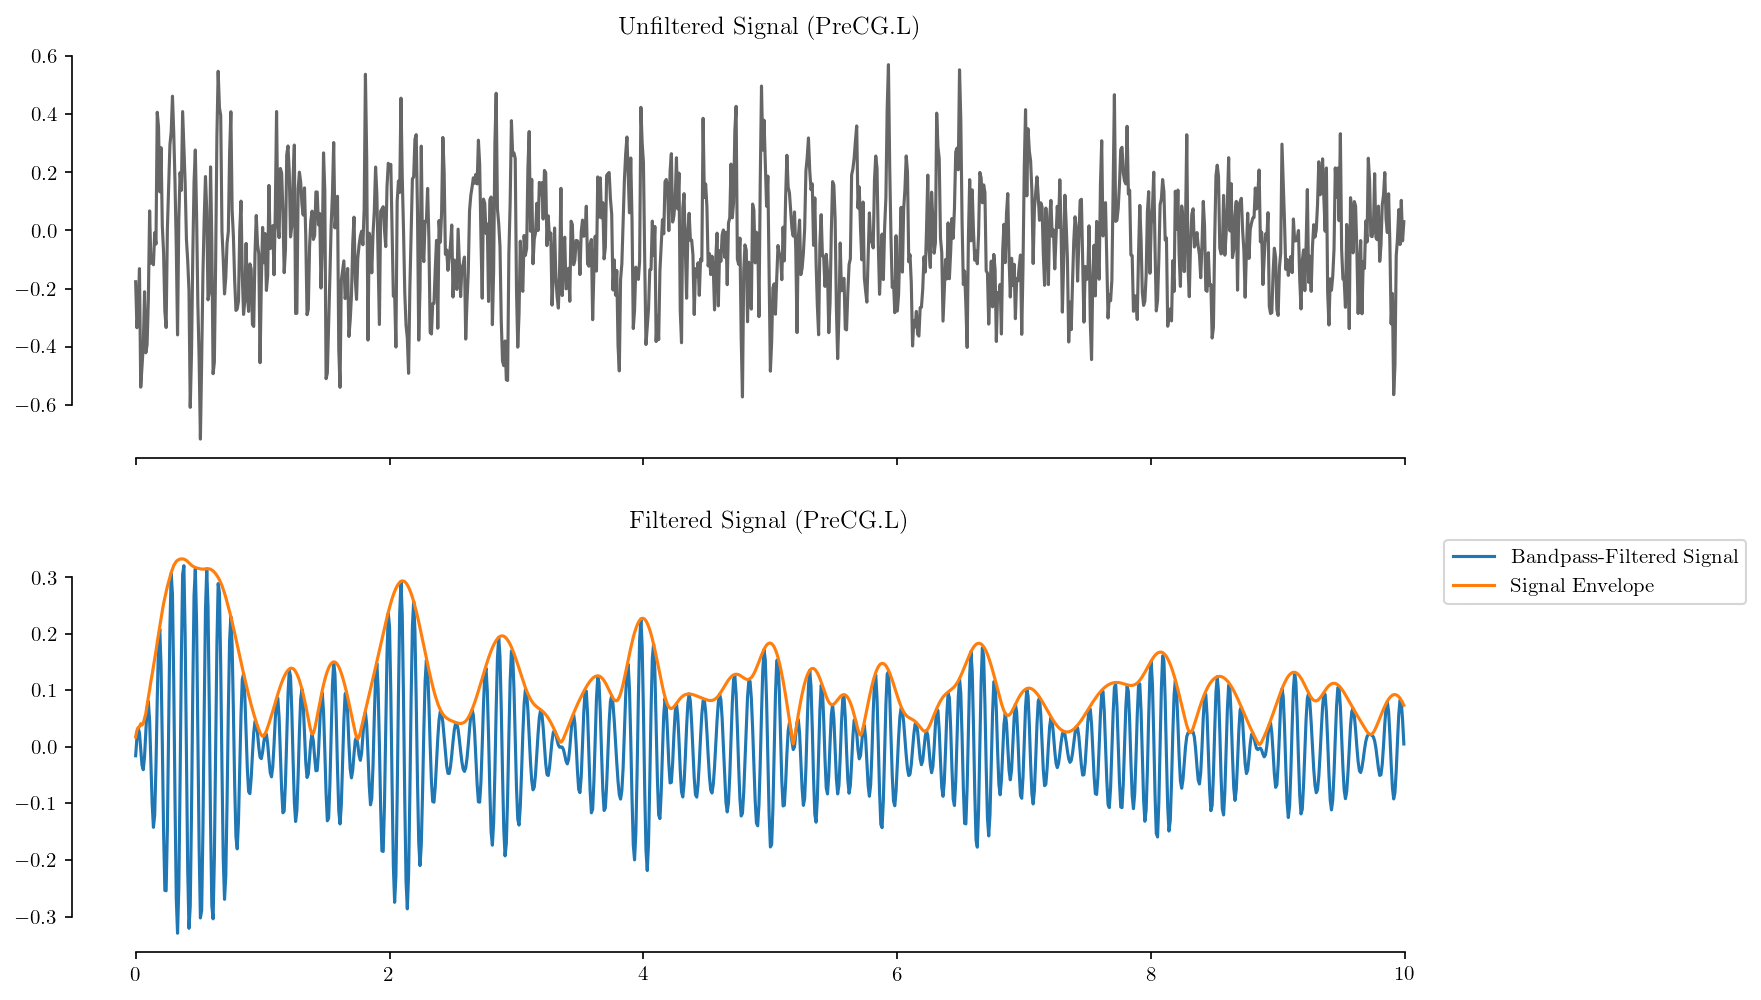

In [5]:
# Define how many timepoints you'd like to plot
plot_timepoints = 1000

# Plot unfiltered Signal
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x=signal.data.time[:plot_timepoints].values, y=signal.data.sel(regions=target.value)[:plot_timepoints].values, 
             ax=ax[0], color='k', alpha=0.6)
ax[0].set_title(f'Unfiltered Signal ({target.value})');

# Band Pass Filter the Signal
signal.filter(freq.value[0], freq.value[1], inplace=True);

# Apply hilbert-transform to extract the signal envelope
complex_signal = signal.hilbert_transform('complex', inplace=False)
signal_env = np.abs(complex_signal.data)

# Plot filtered Signal and Signal Envelope
sns.lineplot(x=signal.data.time[:plot_timepoints].values, y=signal.data.sel(regions=target.value)[:plot_timepoints].values, 
             ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=signal_env.time[:plot_timepoints].values, y=signal_env.sel(regions=target.value)[:plot_timepoints].values, 
             ax=ax[1], label='Signal Envelope')
ax[1].set_title(f'Filtered Signal ({target.value})');
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
sns.despine(trim=True)

### Orthogonalized signal envelope

Now we are going to address the main methodological issue of MEG when it comes to the analysis of the cortical
functional connectivity structure, i.e. its low spatial resolution. The electric field
generated by any given neural source spreads widely over the cortex so that the signal captured at the MEG sensors is a complex mixture of signals from multiple underlying neural sources.

To account for the effect of electric field spread on our MEG connectivity measures, we adapted the orthogonalization approach by  *Hipp, J., Hawellek, D., Corbetta, M. et al. Large-scale cortical correlation structure of spontaneous oscillatory activity. Nat Neurosci 15, 884–890 (2012) __[link](https://doi.org/10.1038/nn.3101)__*.

The basic idea here is that a signal generated by one neural source and measured at two separate sensors must have exactly the same phase at both sensors. In contrast, signals from different neural sources have different phases. And thus it is possible to eliminate the effect of a reference signal on the target signal by removing the signal component that has the same phase as a reference region.

Formally, this can be expressed as: $Y_{\perp X}(t,f) = imag\big(\ Y(t,f)\ \frac{X(t,f)^\star}{|X(t,f)|}\ \big)\ \label{eq:orth}$. Here, $Y$ represents the analytic signal from our target regions that is being orthogonalized with respect to the signal from region $X$.

Using the widgets below, you can choose the reference region $X$ *(default: right Precentral Gyrus)*

In [6]:
print('Select a reference region for the orthogonalization')
# Select a Region 
referenz = widgets.Select(options=region_labels, value='PreCG.R', description='Regions',
                          tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
                          layout=widgets.Layout(width='50%', height='150px'))
display(referenz)

Select a reference region for the orthogonalization


Select(description='Regions', index=1, layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.…

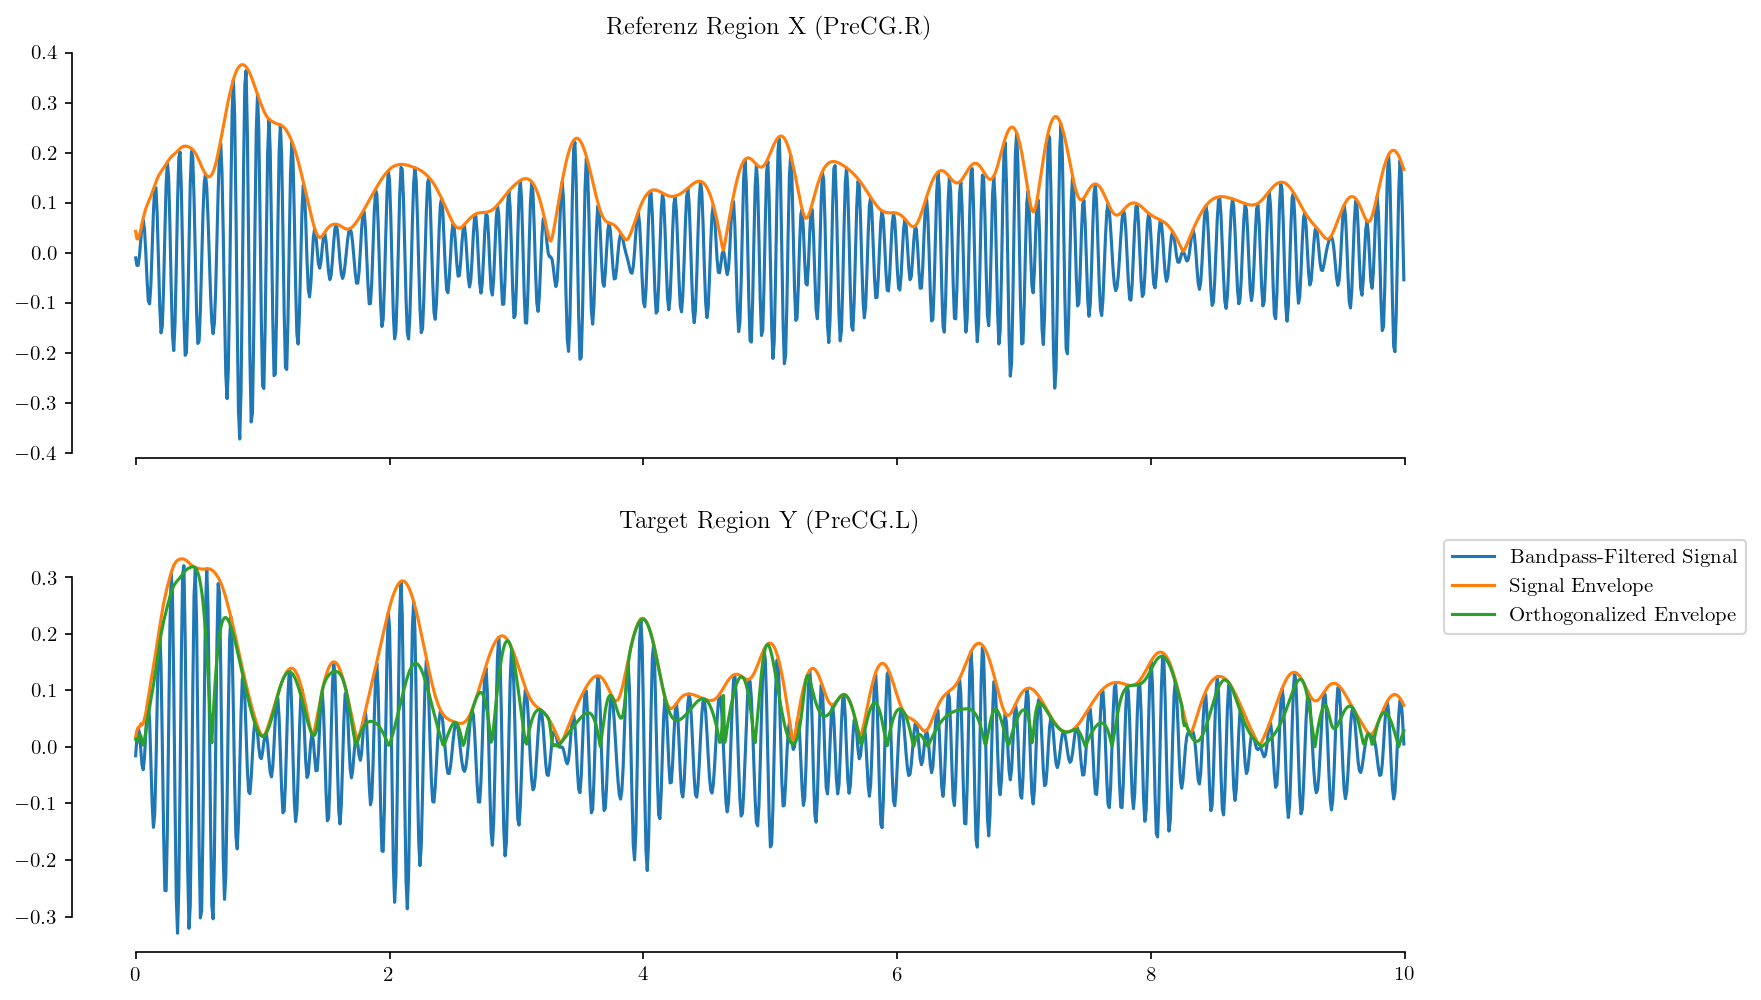

In [7]:
# Perform Orthogonalization
signal_conj = complex_signal.data.conj()
conj_div_env = signal_conj/signal_env
orth_signal = (complex_signal.data.sel(regions=target.value) * conj_div_env.sel(regions=referenz.value)).imag
orth_env = np.abs(orth_signal)

# Plot 
fig, ax = plt.subplots(2,1,figsize=(12,8), sharex=True)
sns.lineplot(x=signal.data.time[:plot_timepoints].values, y=signal.data.sel(regions=referenz.value)[:plot_timepoints].values, ax=ax[0])
sns.lineplot(x=signal_env.time[:plot_timepoints].values, y=signal_env.sel(regions=referenz.value)[:plot_timepoints].values, ax=ax[0])
ax[0].set_title(f'Referenz Region X ({referenz.value})');
sns.lineplot(x=signal.data.time[:plot_timepoints].values, y=signal.data.sel(regions=target.value)[:plot_timepoints].values, 
             ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=signal_env.time[:plot_timepoints].values, y=signal_env.sel(regions=target.value)[:plot_timepoints].values, 
             ax=ax[1], label='Signal Envelope')
sns.lineplot(x = orth_env.time[:plot_timepoints].values, y=orth_env[:plot_timepoints].values, ax=ax[1], label='Orthogonalized Envelope')
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax[1].set_title(f'Target Region Y ({target.value})');
sns.despine(trim=True)

### Low-Pass filtering of the envelopes 

As a last step, before calculating the envelope correlations, we need to low-pass filter the signal envelopes since the connectivity measures of (ultra)-low frequency components of the MEG-signal correspond best to the functional connectivity as measured using fMRI.

Below, you can choose the low-pass frequency *(default: 0.2 Hz)*.

In [8]:
low_pass = widgets.FloatSlider(value=0.2, min=0, max=2.0, step=0.1, description='Low-Pass Frequency (Hz)', 
                               disabled=False, readout=True, readout_format='.1f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(low_pass)

FloatSlider(value=0.2, description='Low-Pass Frequency (Hz)', layout=Layout(width='80%'), max=2.0, readout_for…

Orthogonalized envelope correlation between PreCG.R and PreCG.L:  -0.04


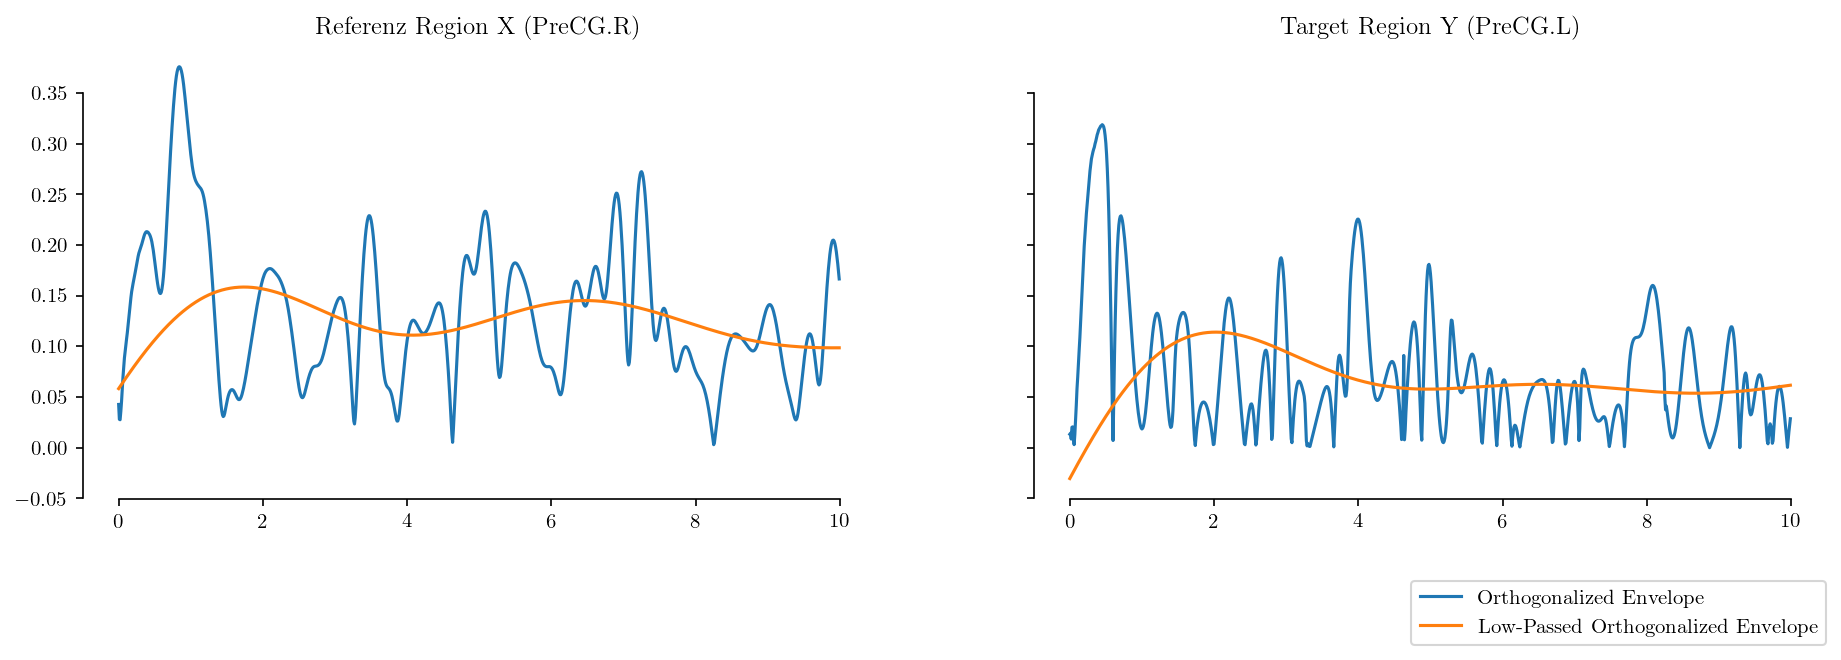

In [9]:
with io.capture_output() as captured:
    low_orth_env = Signal(orth_env).filter(low_freq=None, high_freq=low_pass.value, inplace=False)
    low_signal_env = Signal(signal_env.sel(regions=referenz.value)).filter(low_freq=None, high_freq=low_pass.value, inplace=False)

# Plot
fig, ax = plt.subplots(1,2,figsize=(15,4), sharey=True)
sns.lineplot(x=signal_env.time[:plot_timepoints].values, y=signal_env.sel(regions=referenz.value)[:plot_timepoints].values, ax=ax[0])
sns.lineplot(x=low_signal_env.data.time[:plot_timepoints].values, y=low_signal_env.data[:plot_timepoints].values, ax=ax[0])
ax[0].set_title(f'Referenz Region X ({referenz.value})');
sns.lineplot(x = orth_env.time[:plot_timepoints].values, y=orth_env[:plot_timepoints].values, ax=ax[1], label='Orthogonalized Envelope')
sns.lineplot(x = low_orth_env.data.time[:plot_timepoints].values, y=low_orth_env.data[:plot_timepoints].values, ax=ax[1], label='Low-Passed Orthogonalized Envelope')
ax[1].legend(bbox_to_anchor=(1, -0.18),borderaxespad=0)
ax[1].set_title(f'Target Region Y ({target.value})');
sns.despine(trim=True)
print(f'Orthogonalized envelope correlation between {referenz.value} and {target.value}: ', np.round(np.corrcoef(low_orth_env.data,low_signal_env.data)[0,1],2))

### Computing the functional connectivity matrix

We will now define a function that iterates over each pair of brain regions and performs the previously presented processing steps, i.e. that extracts the envelopes, performs the orthogonalization, applies the low-pass filter, and returns the functional connectivity matrix that contains the pairwise envelope correlations. 

This step may take a minute.

In [10]:
def orth_fc(signal, low_pass):   
    nr_regions = signal.data.shape[0]
    progress = widgets.IntProgress(min=0, max=nr_regions, description=('Calculating FC Matrix'),
                                   layout=widgets.Layout(width='80%'), style={'description_width': 'initial'})
    display(progress)
    complex_signal = signal.hilbert_transform('complex', inplace=False)
    signal_env = signal.hilbert_transform('amplitude', inplace=False);
    conj_div_env = complex_signal.data.conj()/signal_env.data    
    
    # Low-pass filter Signal envelope
    with io.capture_output() as captured:
        signal_env.filter(low_freq=None, high_freq=low_pass)
    
    corr = []
    for complex_region in complex_signal.data: 
        orth_signal = (complex_region * conj_div_env).imag
        orth_env = np.abs(orth_signal).T
        orth_env = Signal(orth_env)
        with io.capture_output() as captured:
            orth_env.filter(low_freq=None, high_freq=low_pass)
        corr_mat = np.corrcoef(orth_env.data, signal_env.data)
        corr.append(np.diag(corr_mat, k=nr_regions))
        progress.value += 1

    fc = np.array(corr)
    # Since the orthogonalization process is not symmetric we take the mean of both directions.
    fc = (fc.T + fc) / 2.
    np.fill_diagonal(fc,0)
    return fc

# Execute Function
fc = orth_fc(signal, low_pass.value)

IntProgress(value=0, description='Calculating FC Matrix', layout=Layout(width='80%'), max=94, style=ProgressSt…

Let's now plot the functional connectivity matrix. We label only every second row/column since right and left regions alternate in the AAL2 atlas.

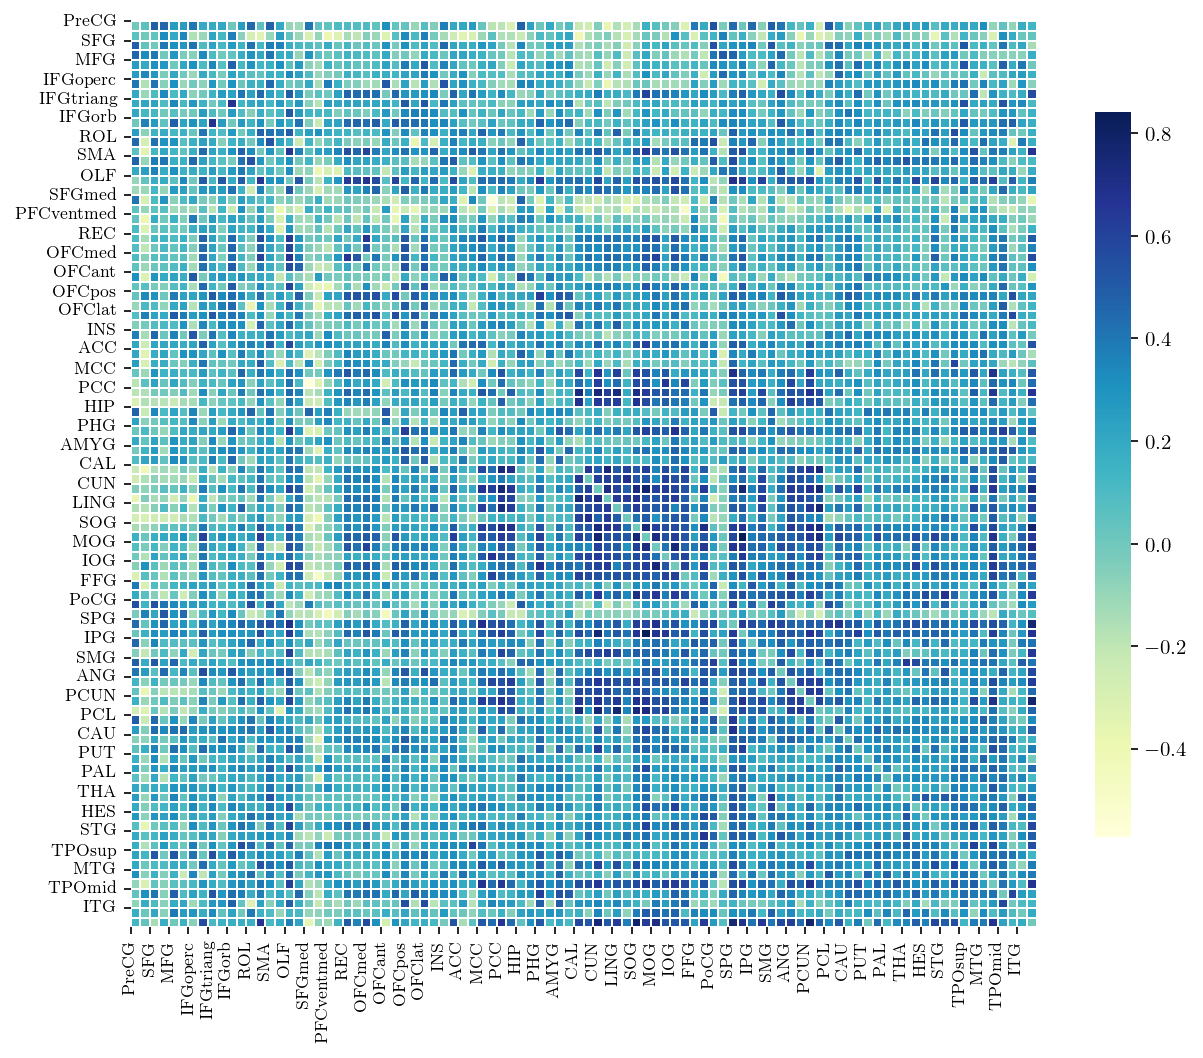

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fc, square=True, ax=ax, cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .8})
ticks = [tick[:-2] for tick in region_labels[::2]]
ax.set_xticks(np.arange(0,94,2)); ax.set_yticks(np.arange(0,94,2))    
ax.set_xticklabels(ticks, rotation=90, fontsize=8); ax.set_yticklabels(ticks, rotation=0, fontsize=8);

#### Exclude subcortical regions
For the following whole-brain simulation we are only interested in the cortical regions. So we'll now exclude all subcortical regions: 
* Hippocampus: 41 - 44
* Amygdala: 45-46
* Basal Ganglia: 75-80
* Thalamus: 81-82

> Attention: AAL indices start with 1

In [12]:
exclude = list(range(40, 46)) + list(range(74, 82))
tmp = np.delete(fc, exclude, axis=0)
emp_fc = np.delete(tmp, exclude, axis=1)
# Exclude regions from the list of region labels
emp_labels = np.delete(region_labels, exclude)

## Whole-brain model

In this part of the notebook, we will use `neurolib` to simulate the functional connectivity. We will therefore:

* Load structural connectivity matrices from the *Human Connectome Project* and initiate the whole-brain model using the Wilson-Cowan model to simulate each brain region
* Set the *global coupling strength*, *exc. background input*, and the *noise strength* parameters of the model
* Run the simulation
* Compute the functional connectivity using the signal envelopes

Please refer to the `wc-minimal` example for an introduction to the Wilson-Cowan model.

#### Initiate whole-brain model

In [13]:
data_path = "/Users/pamirozsuna/Desktop/pamir_ma/SCZ-FC-modelling"

In [14]:
def averageMat(Mat):
    avMat = np.zeros((94,94))
    for i in range(len(Mat)):
        avMat = avMat + Mat[i]
    avMat = avMat/len(Mat)
    return avMat

In [15]:
from neurolib.utils.loadData import filterSubcortical
C_data = np.load(data_path+"/AvgCmatrixHC.npy")
D_data = np.load(data_path+"/AvgDmatrixHC.npy")
Cmat_tmp = averageMat(C_data)
Dmat_tmp = averageMat(D_data)
Cmat = filterSubcortical(Cmat_tmp)
Dmat = filterSubcortical(Dmat_tmp)
FC_data = np.load(data_path+"/AvgFmatrixHC.npy")
timeseries = np.load(data_path+"/AvgTmatrixHC.npy")
FC_tmp = averageMat(FC_data)
FCs = filterSubcortical(FC_tmp)


C_data_s = np.load(data_path+"/AvgCmatrixSCZ.npy")
D_data_s = np.load(data_path+"/AvgDmatrixSCZ.npy")
Cmat_tmp_s = averageMat(C_data_s)
Dmat_tmp_s = averageMat(D_data_s)
Cmat_s = filterSubcortical(Cmat_tmp_s)
Dmat_s = filterSubcortical(Dmat_tmp_s)
FC_data_s = np.load(data_path+"/AvgFmatrixSCZ.npy")
timeseries_s = np.load(data_path+"/AvgTmatrixSCZ.npy")
FC_tmp_s = averageMat(FC_data_s)
FCs_s = filterSubcortical(FC_tmp_s)

In [16]:
# Let's import the neurolib
from neurolib.models.wc import WCModel
from neurolib.models.wc_heterogeneous import WCModelHeterogeneous
from neurolib.utils.loadData import Dataset

# First we load the structural data set from the Human Connectome Project 
#ds = Dataset("hcp")

# We initiate the Wilson-Cowan model
wc = WCModel(Cmat = Cmat, Dmat = Dmat, seed=0)

wc_scz = WCModel(Cmat = Cmat_s, Dmat = Dmat_s, seed=0)
wc_frontal = WCModelHeterogeneous(Cmat = Cmat_s, Dmat = Dmat_s, seed=0)
wc_temporal = WCModelHeterogeneous(Cmat = Cmat_s, Dmat = Dmat_s, seed=0)
wc_parietal = WCModelHeterogeneous(Cmat = Cmat_s, Dmat = Dmat_s, seed=0)
wc_occipital = WCModelHeterogeneous(Cmat = Cmat_s, Dmat = Dmat_s, seed=0)

#### Parameter settings

You may now choose parameters settings for the *global coupling*, the *excitatory background input*, and the *noise strength*, which will be used when we run the model. The final fit between simulated and empirical connectivity matrices will depend on the parameters choosen here.

In [17]:
global_coupling = widgets.FloatSlider(value=6.55, min=0., max=20.0, step=0.01, description='Global Coupling', 
                               disabled=False, readout=True, readout_format='.2f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
exc_drive = widgets.FloatSlider(value=1.58, min=0.0, max=4.0, step=0.01, description='Exc. Background Drive', 
                               disabled=False, readout=True, readout_format='.2f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
inh_drive = widgets.FloatSlider(value=2.83, min=0.0, max=4.0, step=0.01, description='Inh. Background Drive', 
                               disabled=False, readout=True, readout_format='.2f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
noise_level = widgets.FloatSlider(value=0.02, min=0.001, max=0.05, step=0.001, description='Noise Level', 
                               disabled=False, readout=True, readout_format='.3f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(global_coupling)
display(exc_drive)
display(inh_drive)
display(noise_level)

FloatSlider(value=6.55, description='Global Coupling', layout=Layout(width='80%'), max=20.0, step=0.01, style=…

FloatSlider(value=1.58, description='Exc. Background Drive', layout=Layout(width='80%'), max=4.0, step=0.01, s…

FloatSlider(value=2.83, description='Inh. Background Drive', layout=Layout(width='80%'), max=4.0, step=0.01, s…

FloatSlider(value=0.02, description='Noise Level', layout=Layout(width='80%'), max=0.05, min=0.001, readout_fo…

#### Run the simulation

Let's now run the whole-brain model using the defined parameter settings. This may take some time since we're simulating a complete minute here. 

In [18]:
# Let's set the previously defined parameters
# note: the duraiton here is short for testing:
#wc.params['duration'] = 10*1000 

# use longer simulation for real run:
wc.params['duration'] = 1*60*1000 

#wc.params['K_gl'] = global_coupling.value
#wc.params['exc_ext'] = exc_drive.value
#wc.params['inh_ext'] = inh_drive.value
#wc.params['sigma_ou'] = noise_level.value
wc.params['exc_ext'] = 0.45
wc.params['c_excinh'] = 10.33
wc.params['c_inhexc'] = 9.67
wc.params['c_inhinh'] = 0
wc.params['K_gl'] = 1.84
wc.params['sigma_ou'] = 4.28e-05

# Run the model
wc.run()

In [19]:
# Let's set the previously defined parameters
# note: the duraiton here is short for testing:
#wc.params['duration'] = 10*1000 

# use longer simulation for real run:
wc_scz.params['duration'] = 1*60*1000 

#wc.params['K_gl'] = global_coupling.value
#wc.params['exc_ext'] = exc_drive.value
#wc.params['inh_ext'] = inh_drive.value
#wc.params['sigma_ou'] = noise_level.value
wc_scz.params['exc_ext'] = 0.5
wc_scz.params['c_excinh'] = 10.0
wc_scz.params['c_inhexc'] = 8.67
wc_scz.params['c_inhinh'] = 0.22
wc_scz.params['K_gl'] = 1.84
wc_scz.params['sigma_ou'] = 4.28e-05
wc_scz.run()

### Simulated functional connectivity

We'll now compute the functional connectivity matrix containing the pairwise envelope correlations between all cortical regions of the AAL2 atlas. We'll thus follow the processing steps as before, i.e. band-pass filter the signal, extract the signal envelopes using the hilbert transformation, low-pass filter the envelopes and compute the pairwise pearson correlations. Note that we don't apply the orthogonalization scheme here, since this was only done to account to the electric field spread in the empirical data. 

8
12


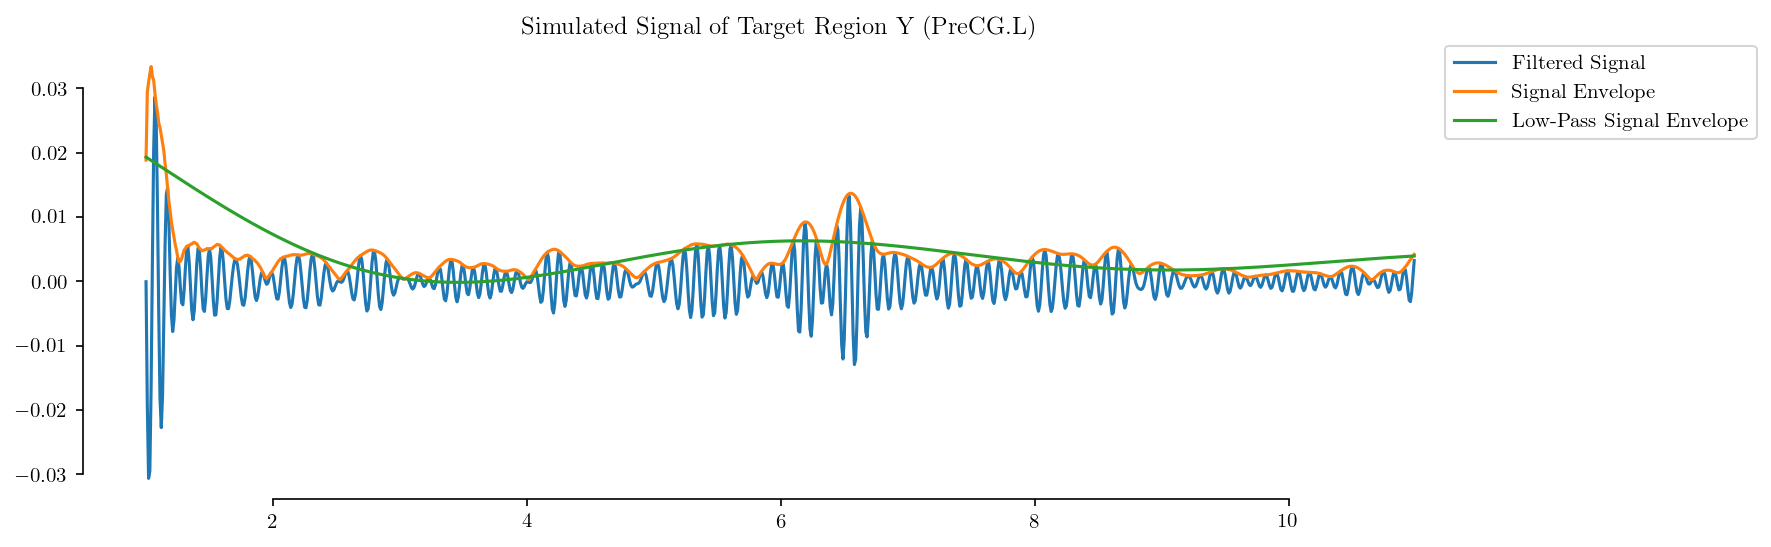

In [20]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal = xr.DataArray(wc.exc[:, int(1000/wc.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal = Signal(sim_signal)
sim_signal.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal.data.time[:plot_timepoints].values, y=sim_signal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal.data.time[:plot_timepoints].values, y=sim_signal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal.data.time[:plot_timepoints].values, y=sim_signal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

8
12


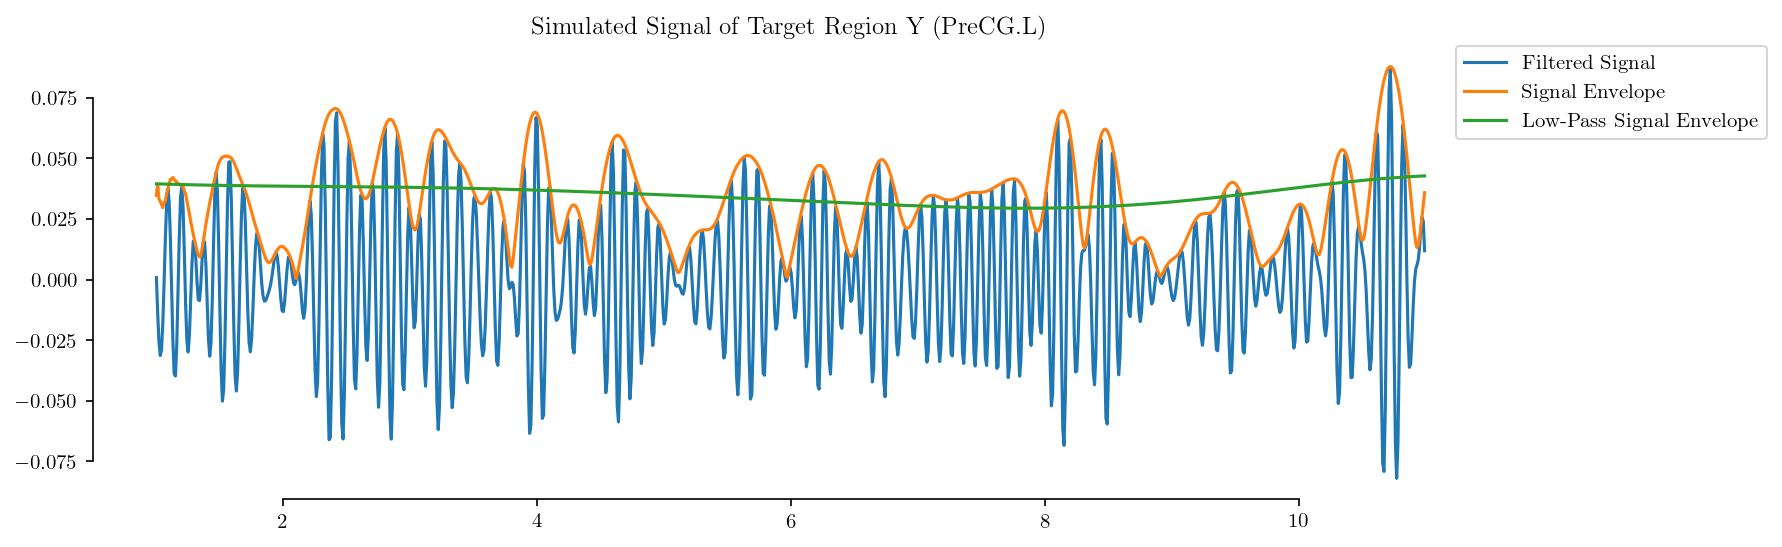

In [21]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal_scz = xr.DataArray(wc_scz.exc[:, int(1000/wc_scz.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc_scz.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal_scz = Signal(sim_signal_scz)
sim_signal_scz.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal_scz.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal_scz.data.time[:plot_timepoints].values, y=sim_signal_scz.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal_scz.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal_scz.data.time[:plot_timepoints].values, y=sim_signal_scz.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal_scz.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal_scz.data.time[:plot_timepoints].values, y=sim_signal_scz.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

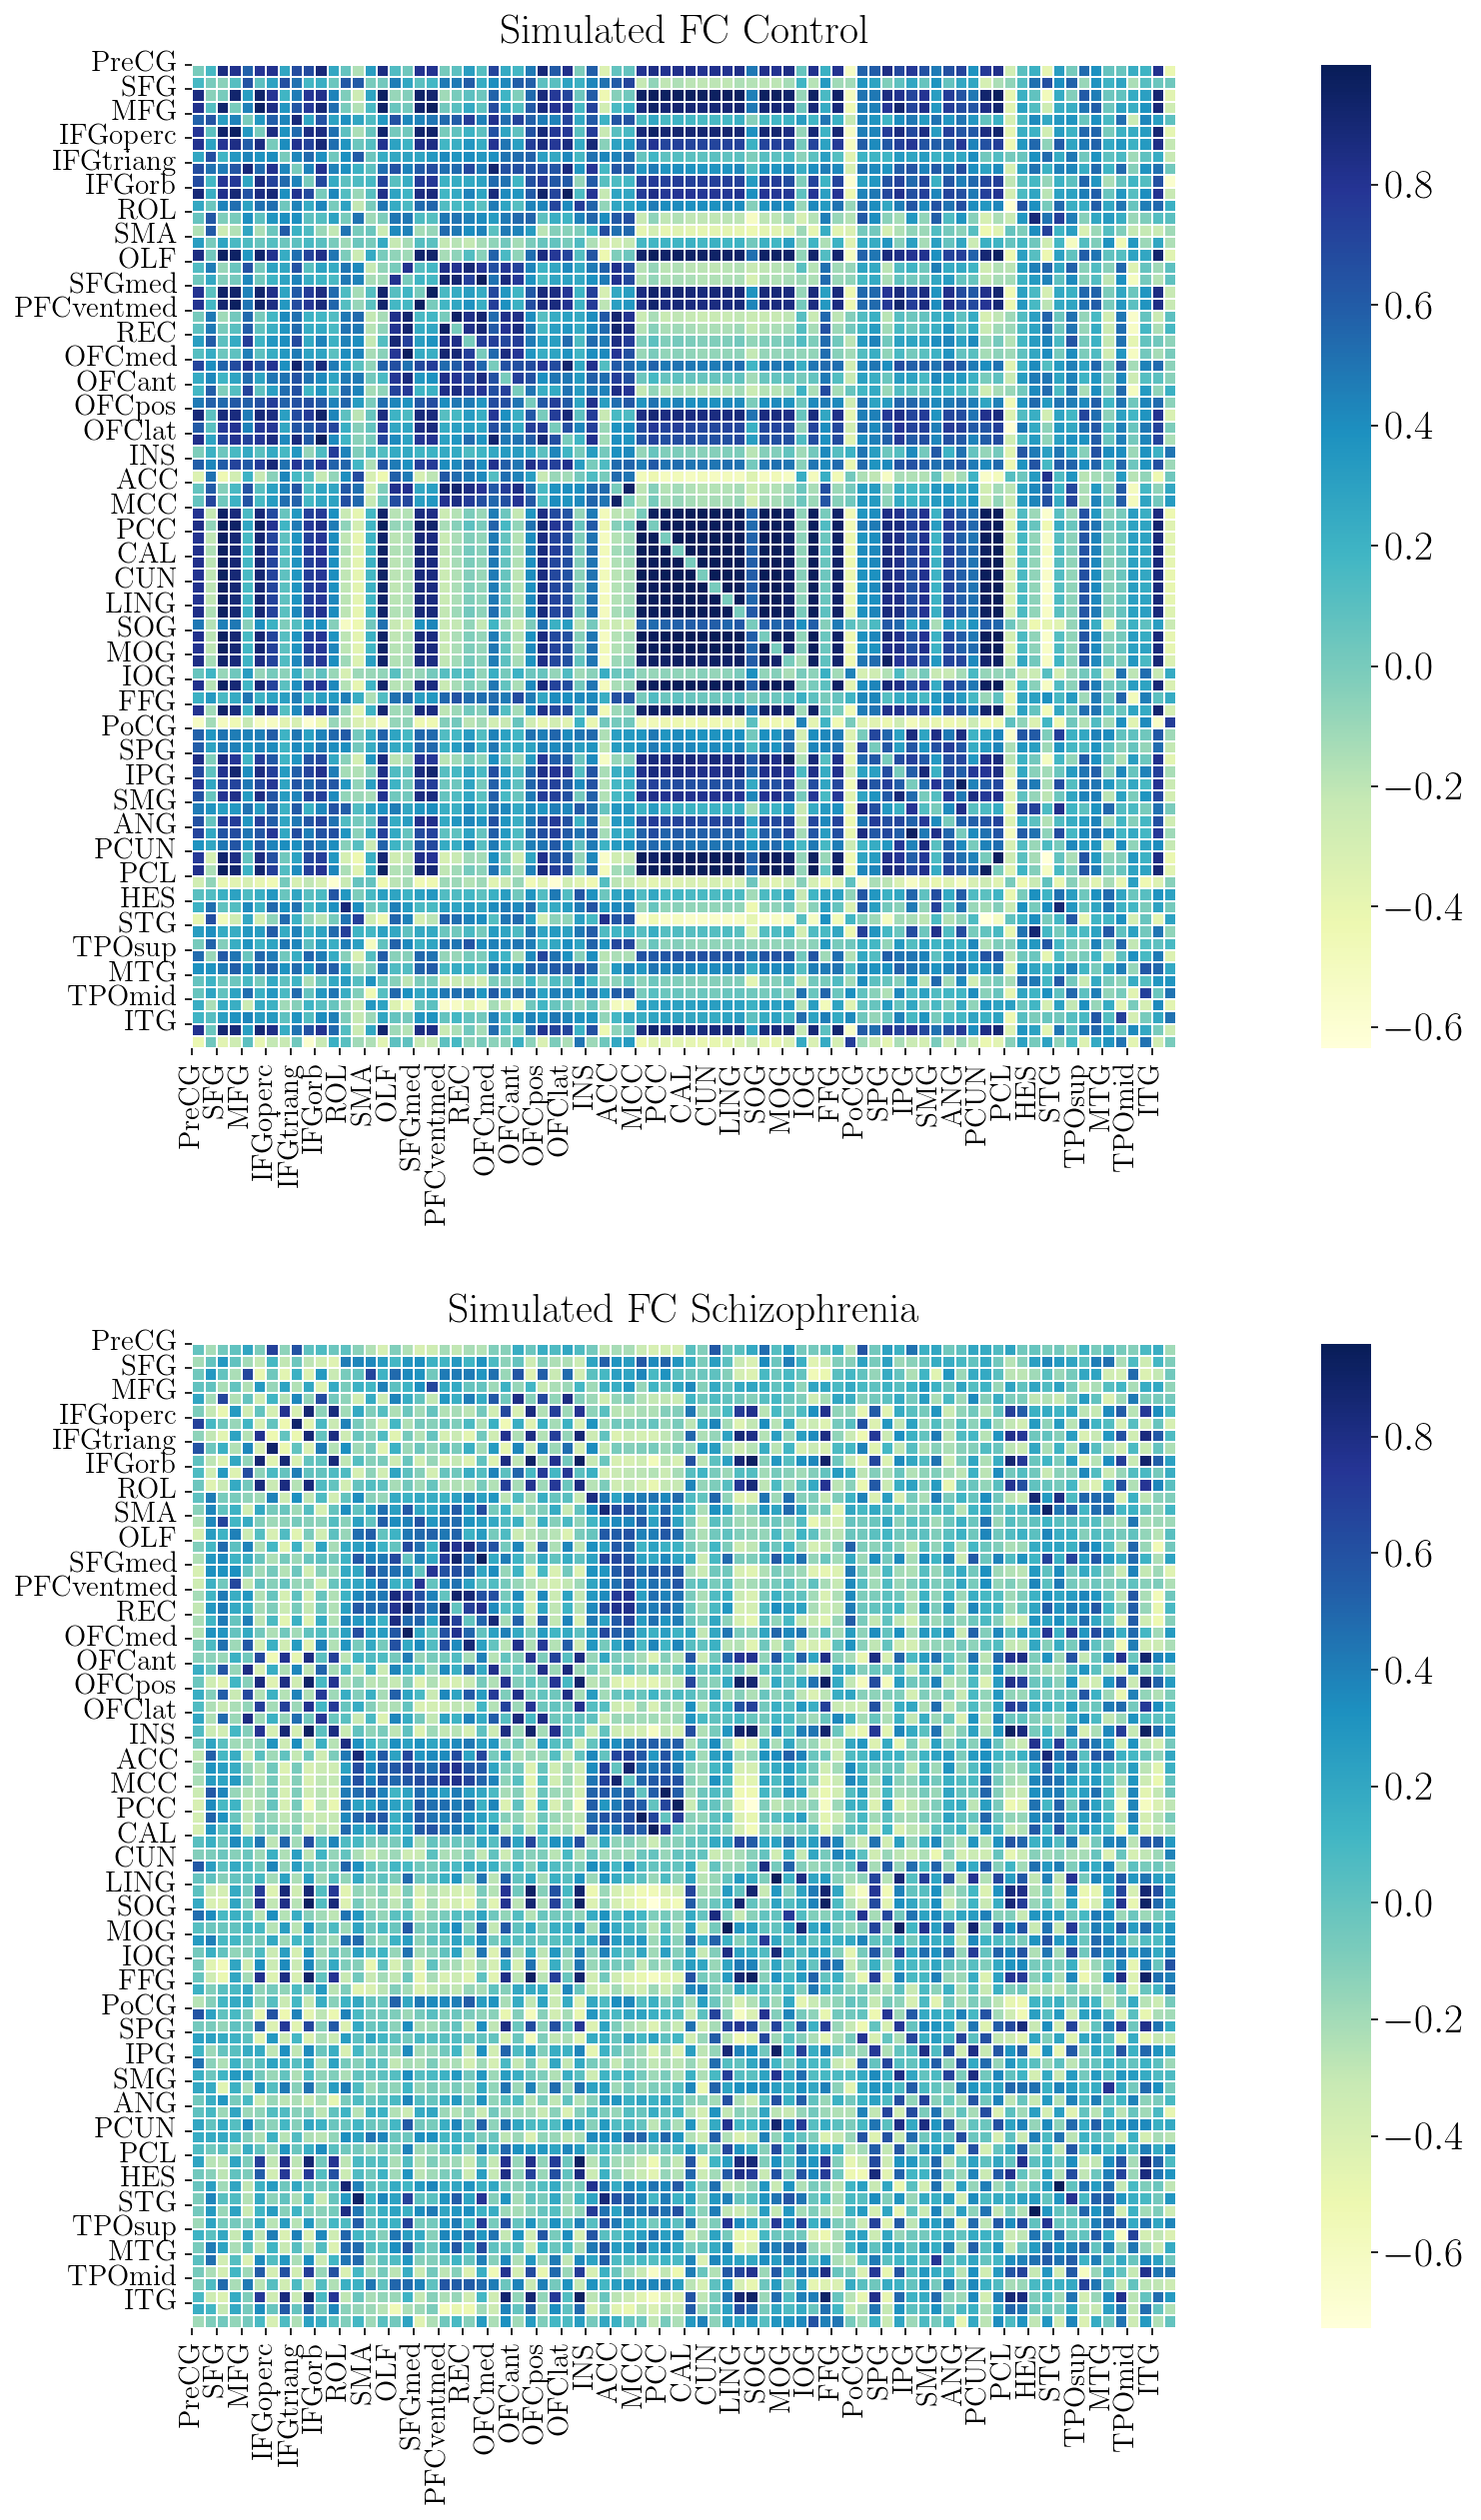

In [58]:
import neurolib.utils.functions as func

# Compute the functional connectivity matrix
sim_fc = func.fc(sim_signal.data)
sim_fc_scz = func.fc(sim_signal_scz.data)
# Set diagonal to zero
np.fill_diagonal(sim_fc, 0)
np.fill_diagonal(sim_fc_scz, 0)

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(2,1, figsize=(25,20))
#sns.heatmap(emp_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .5})
#ax[0].set_title('Empirical FC',pad=10);
sns.heatmap(sim_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005)
ax[0].set_title('Simulated FC Control',pad=10, fontsize=20);
sns.heatmap(sim_fc_scz, square=True, ax=ax[1], cmap='YlGnBu', linewidth=0.005)
ax[1].set_title('Simulated FC Schizophrenia',pad=10, fontsize=20);
ticks = [tick[:-2] for tick in emp_labels[::2]]
for ax in ax:
    ax.set_xticks(np.arange(0,80,2)); ax.set_yticks(np.arange(0,80,2))    
    ax.set_xticklabels(ticks, rotation=90, fontsize=14); ax.set_yticklabels(ticks, rotation=0, fontsize=14);
fig.subplots_adjust(hspace=0.3)
fig.savefig('meg_comparison1.png',bbox_inches='tight')

To compute the simulated functional connectivity matrix we use the `fc` functions from neurolib. 

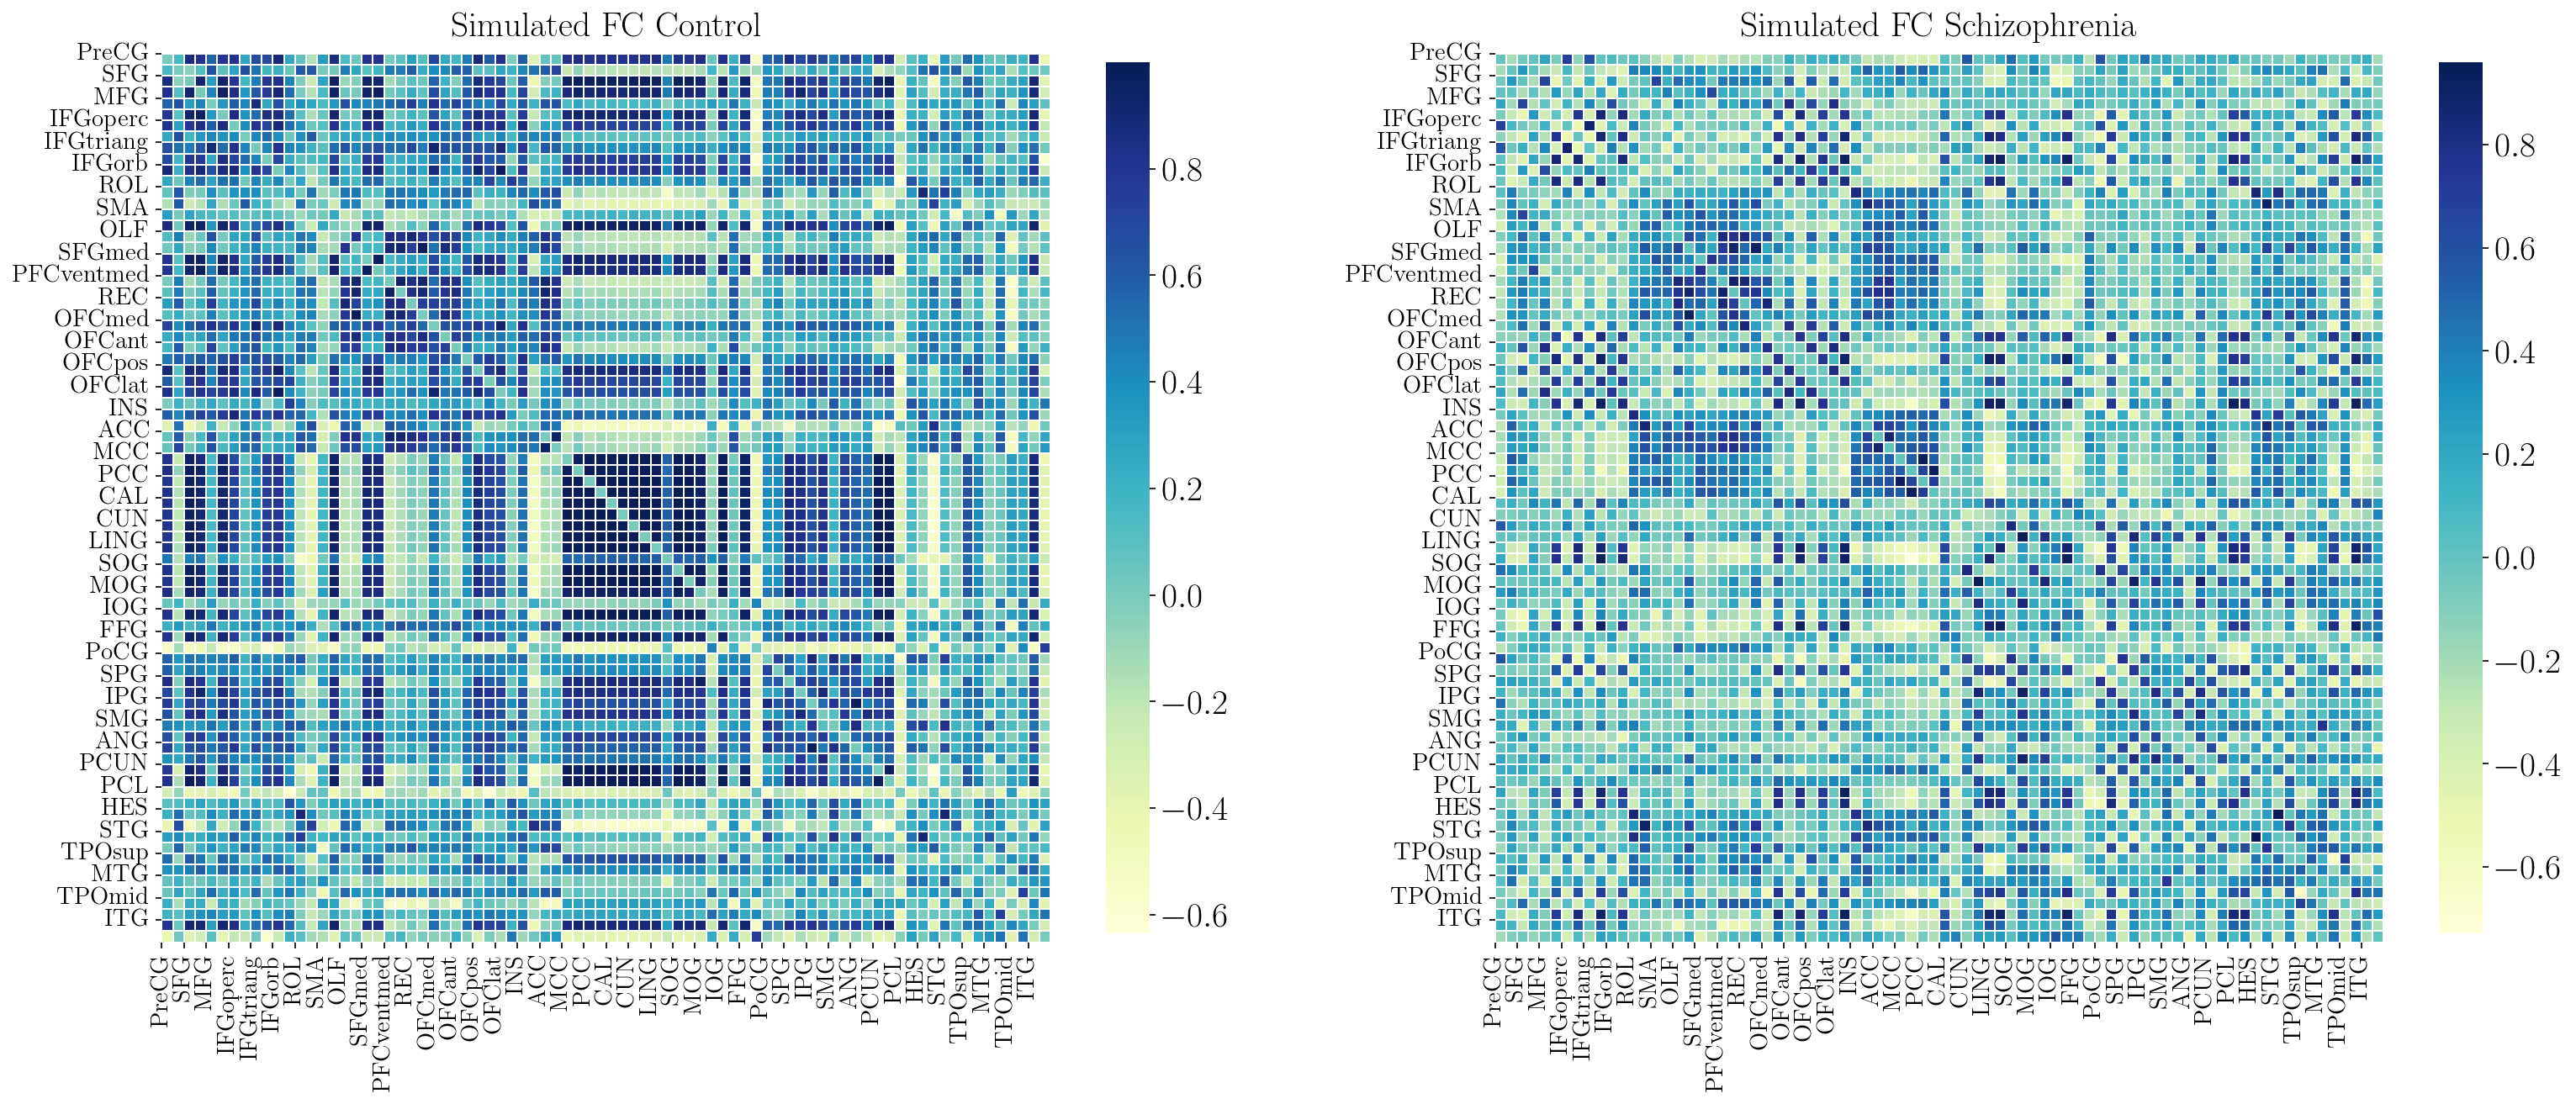

In [63]:
import neurolib.utils.functions as func

# Compute the functional connectivity matrix
sim_fc = func.fc(sim_signal.data)
sim_fc_scz = func.fc(sim_signal_scz.data)
# Set diagonal to zero
np.fill_diagonal(sim_fc, 0)
np.fill_diagonal(sim_fc_scz, 0)

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(1,2, figsize=(25,15))
#sns.heatmap(emp_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .5})
#ax[0].set_title('Empirical FC',pad=10);
sns.heatmap(sim_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .61})
ax[0].set_title('Simulated FC Control',pad=10, fontsize=20);
sns.heatmap(sim_fc_scz, square=True, ax=ax[1], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .61})
ax[1].set_title('Simulated FC Schizophrenia',pad=10, fontsize=20);
ticks = [tick[:-2] for tick in emp_labels[::2]]
for ax in ax:
    ax.set_xticks(np.arange(0,80,2)); ax.set_yticks(np.arange(0,80,2))    
    ax.set_xticklabels(ticks, rotation=90, fontsize=14); ax.set_yticklabels(ticks, rotation=0, fontsize=14);
fig.savefig('meg_comparison.png',bbox_inches='tight')

In [23]:
#frontal_indices = 1-2,  3-12, 15-32, 35 - 36, 37 - 38, 39 - 40,  73 - 74
frontal_indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
                  29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 67, 68]
#occipital_indices = 13 - 14, 47 - 60
occipital_indices =  [13, 14, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
#parietal_indices =  61 - 62, 63 - 72
parietal_indices = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
#temporal_indices = 33 - 34, 83 - 86, 87 - 88, 89 - 90, 91 - 92, 93 - 94
temporal_indices = [33, 34, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]

In [24]:
ext_exc_tmp = np.full(80, 0.5)
c_excinh_tmp = np.full(80, 10.0)
c_inhexc_tmp = np.full(80, 8.67)
c_inhinh_tmp = np.full(80, 0.22)
k_gl_tmp = np.full(80, 1.84)
sigma_ou_tmp = np.full(80, 4.28e-05)

# use longer simulation for real run:
wc_frontal.params['duration'] = 1*60*1000 
wc_frontal.params['exc_ext'] = ext_exc_tmp
wc_frontal.params['c_excinh'] = c_excinh_tmp
wc_frontal.params['c_inhexc'] = c_inhexc_tmp
wc_frontal.params['c_inhinh'] = c_inhinh_tmp
wc_frontal.params['K_gl'] = k_gl_tmp
wc_frontal.params['sigma_ou'] = sigma_ou_tmp

#0.222497 	0.7500 	11.5 	11.500000 	1.0 	1.600 	0.0250
for i in frontal_indices:
    ext_exc_tmp[i-1] = 0.7500
    c_excinh_tmp[i-1] = 11.5
    c_inhexc_tmp[i-1] = 11.5
    c_inhinh_tmp[i-1] = 1.0
    k_gl_tmp[i-1] = 1.600 
    sigma_ou_tmp[i-1] = 0.0250

wc_frontal.run()

In [25]:
ext_exc_tmp = np.full(80, 0.5)
c_excinh_tmp = np.full(80, 10.0)
c_inhexc_tmp = np.full(80, 8.67)
c_inhinh_tmp = np.full(80, 0.22)
k_gl_tmp = np.full(80, 1.84)
sigma_ou_tmp = np.full(80, 4.28e-05)

# use longer simulation for real run:
wc_temporal.params['duration'] = 1*60*1000 
wc_temporal.params['exc_ext'] = ext_exc_tmp
wc_temporal.params['c_excinh'] = c_excinh_tmp
wc_temporal.params['c_inhexc'] = c_inhexc_tmp
wc_temporal.params['c_inhinh'] = c_inhinh_tmp
wc_temporal.params['K_gl'] = k_gl_tmp
wc_temporal.params['sigma_ou'] = sigma_ou_tmp

#0.221308 	0.4000 	8.0 	11.111111 	1.0 	1.975 	0.0500
for i in temporal_indices:
    ext_exc_tmp[i-1] = 0.4000 
    c_excinh_tmp[i-1] = 8.0
    c_inhexc_tmp[i-1] = 11.111111
    c_inhinh_tmp[i-1] = 1.0
    k_gl_tmp[i-1] = 1.975
    sigma_ou_tmp[i-1] = 0.0500

wc_temporal.run()

In [26]:
ext_exc_tmp = np.full(80, 0.5)
c_excinh_tmp = np.full(80, 10.0)
c_inhexc_tmp = np.full(80, 8.67)
c_inhinh_tmp = np.full(80, 0.22)
k_gl_tmp = np.full(80, 1.84)
sigma_ou_tmp = np.full(80, 4.28e-05)

# use longer simulation for real run:
wc_occipital.params['duration'] = 1*60*1000 
wc_occipital.params['exc_ext'] = ext_exc_tmp
wc_occipital.params['c_excinh'] = c_excinh_tmp
wc_occipital.params['c_inhexc'] = c_inhexc_tmp
wc_occipital.params['c_inhinh'] = c_inhinh_tmp
wc_occipital.params['K_gl'] = k_gl_tmp
wc_occipital.params['sigma_ou'] = sigma_ou_tmp

#0.222575 	0.40 	8.0 	8.388889 	0.5 	1.850 	0.0500
for i in occipital_indices:
    ext_exc_tmp[i-1] = 0.40 
    c_excinh_tmp[i-1] = 8.0
    c_inhexc_tmp[i-1] = 8.388889
    c_inhinh_tmp[i-1] = 0.5
    k_gl_tmp[i-1] = 1.850 
    sigma_ou_tmp[i-1] = 0.0500

wc_occipital.run()

In [27]:
ext_exc_tmp = np.full(80, 0.5)
c_excinh_tmp = np.full(80, 10.0)
c_inhexc_tmp = np.full(80, 8.67)
c_inhinh_tmp = np.full(80, 0.22)
k_gl_tmp = np.full(80, 1.84)
sigma_ou_tmp = np.full(80, 4.28e-05)

# use longer simulation for real run:
wc_parietal.params['duration'] = 1*60*1000 
wc_parietal.params['exc_ext'] = ext_exc_tmp
wc_parietal.params['c_excinh'] = c_excinh_tmp
wc_parietal.params['c_inhexc'] = c_inhexc_tmp
wc_parietal.params['c_inhinh'] = c_inhinh_tmp
wc_parietal.params['K_gl'] = k_gl_tmp
wc_parietal.params['sigma_ou'] = sigma_ou_tmp

#0.221274 	0.6625 	11.5 	11.111111 	0.5 	1.975 	0.0250
for i in parietal_indices:
    ext_exc_tmp[i-1] = 0.6625
    c_excinh_tmp[i-1] = 11.5
    c_inhexc_tmp[i-1] = 11.111111
    c_inhinh_tmp[i-1] = 0.5
    k_gl_tmp[i-1] = 1.975
    sigma_ou_tmp[i-1] = 0.0250

wc_parietal.run()



8
12


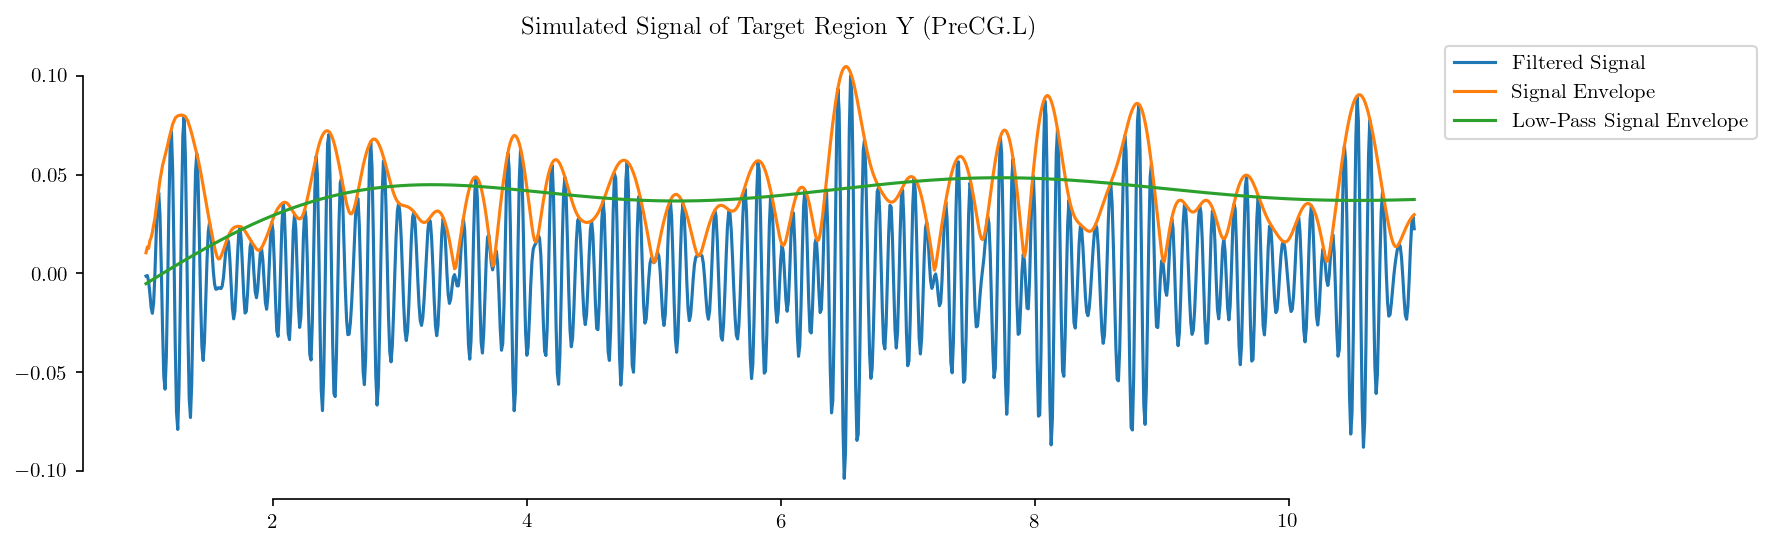

In [28]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal_frontal = xr.DataArray(wc_frontal.exc[:, int(1000/wc_frontal.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc_frontal.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal_frontal = Signal(sim_signal_frontal)
sim_signal_frontal.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal_frontal.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal_frontal.data.time[:plot_timepoints].values, y=sim_signal_frontal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal_frontal.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal_frontal.data.time[:plot_timepoints].values, y=sim_signal_frontal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal_frontal.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal_frontal.data.time[:plot_timepoints].values, y=sim_signal_frontal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

8
12


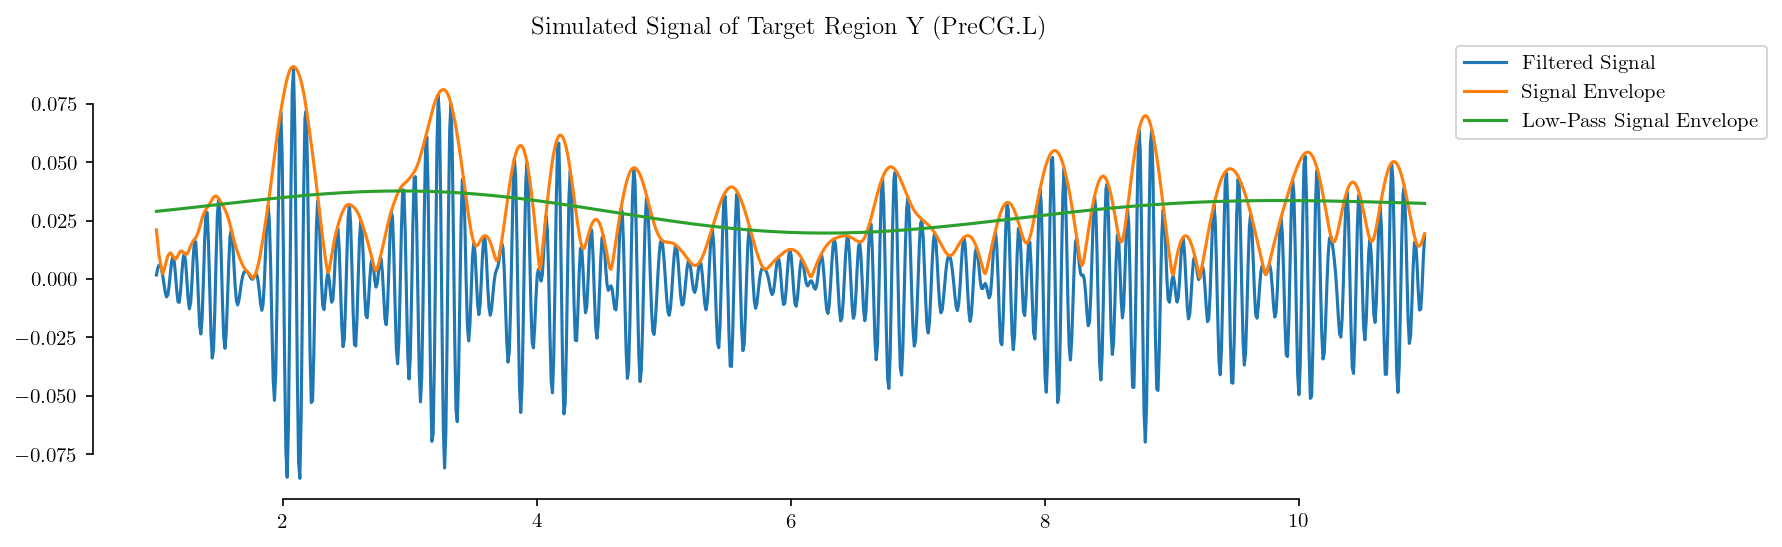

In [29]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal_temporal = xr.DataArray(wc_temporal.exc[:, int(1000/wc_temporal.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc_temporal.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal_temporal = Signal(sim_signal_temporal)
sim_signal_temporal.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal_temporal.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal_temporal.data.time[:plot_timepoints].values, y=sim_signal_temporal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal_temporal.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal_temporal.data.time[:plot_timepoints].values, y=sim_signal_temporal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal_temporal.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal_temporal.data.time[:plot_timepoints].values, y=sim_signal_temporal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

8
12


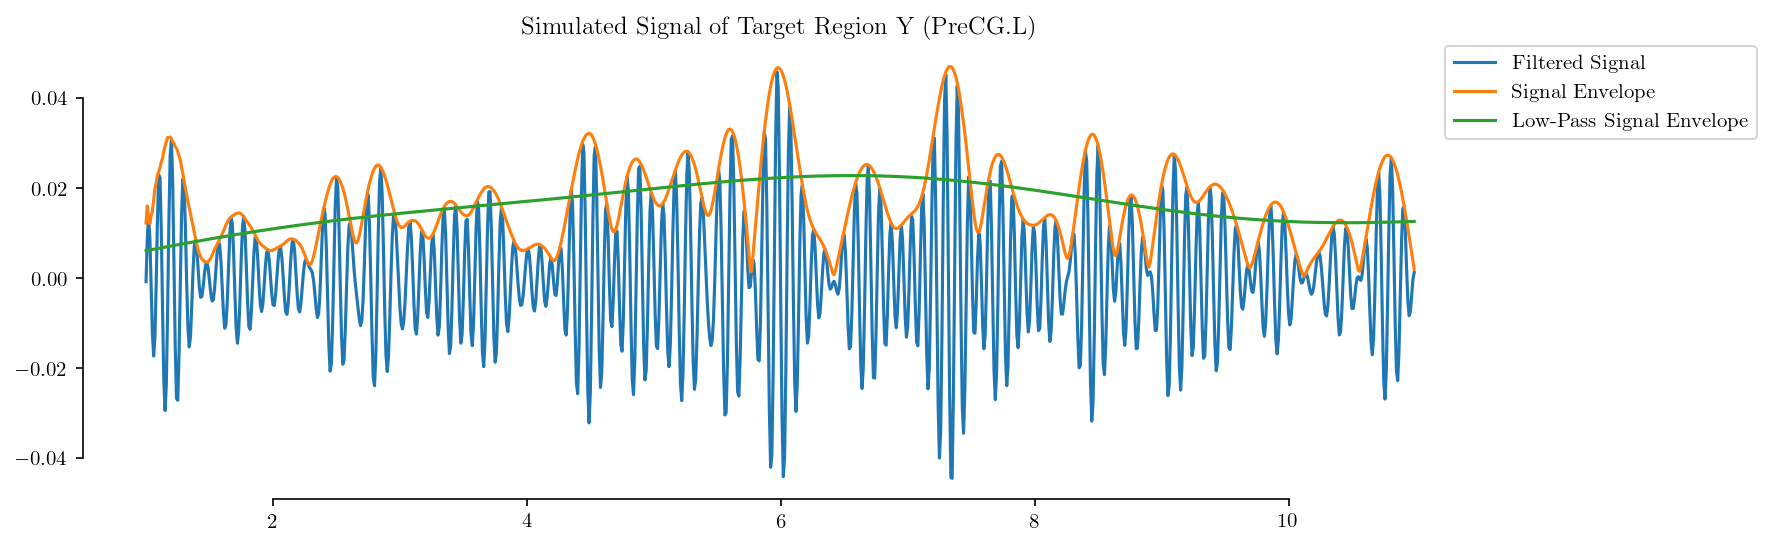

In [30]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal_parietal = xr.DataArray(wc_parietal.exc[:, int(1000/wc_parietal.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc_parietal.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal_parietal = Signal(sim_signal_parietal)
sim_signal_parietal.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal_parietal.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal_parietal.data.time[:plot_timepoints].values, y=sim_signal_parietal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal_parietal.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal_parietal.data.time[:plot_timepoints].values, y=sim_signal_parietal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal_parietal.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal_parietal.data.time[:plot_timepoints].values, y=sim_signal_parietal.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

8
12


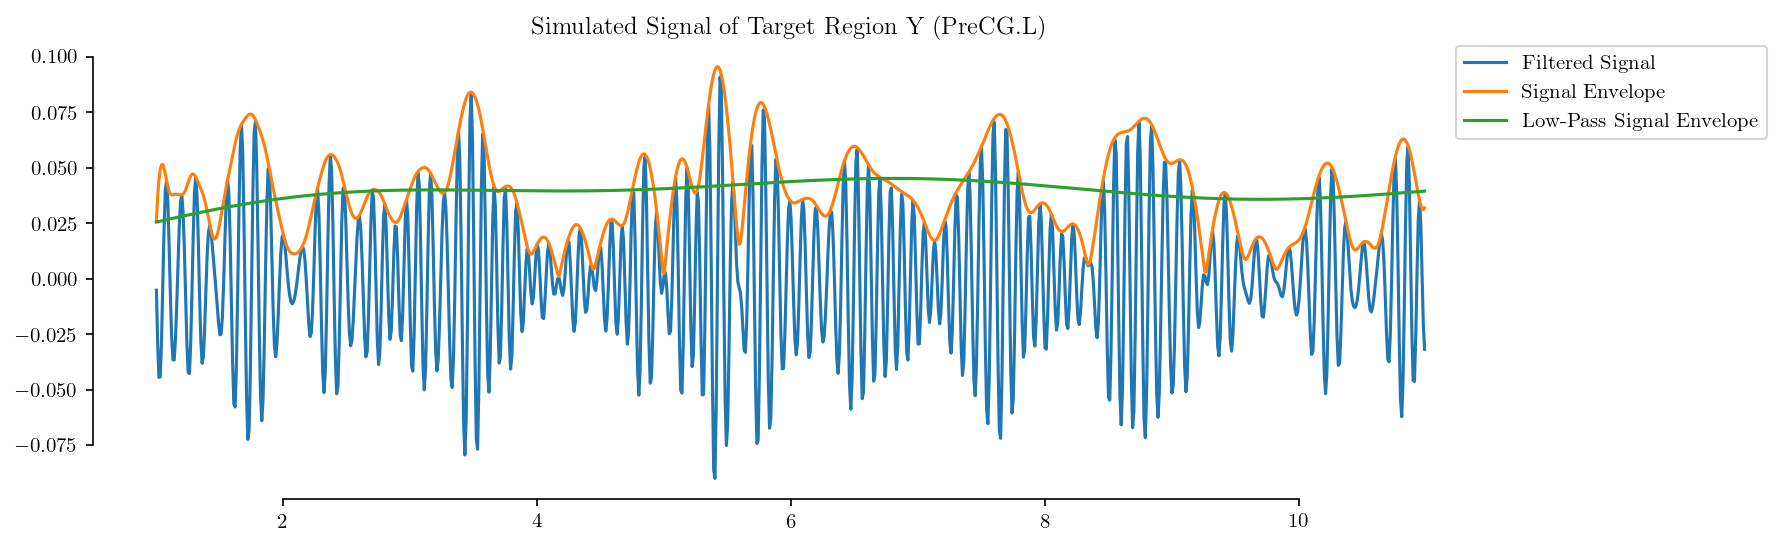

In [31]:
# Create xr DataArray from the simulated excitatory timeseries (keeping the region labels)
sim_signal_occipital = xr.DataArray(wc_occipital.exc[:, int(1000/wc_occipital.params.dt):], dims=("regions", "time"), coords={"regions": emp_labels, "time": wc_occipital.t[int(1000/wc.params.dt):]/1000}, 
                          attrs={'atlas':'AAL2'})

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,4))

print(freq.value[0])
print(freq.value[1])


# Filter signal
sim_signal_occipital = Signal(sim_signal_occipital)
sim_signal_occipital.resample(to_frequency=100)
with io.capture_output() as captured:
    sim_signal_occipital.filter(freq.value[0], freq.value[1], inplace=True);
sns.lineplot(x=sim_signal_occipital.data.time[:plot_timepoints].values, y=sim_signal_occipital.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Filtered Signal')

# Extract signal envelope 
sim_signal_occipital.hilbert_transform('amplitude', inplace=True)
sns.lineplot(x=sim_signal_occipital.data.time[:plot_timepoints].values, y=sim_signal_occipital.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Signal Envelope')

# Low-Pass Filter
with io.capture_output() as captured:
    sim_signal_occipital.filter(low_freq=None, high_freq=low_pass.value, inplace=True)
sns.lineplot(x=sim_signal_occipital.data.time[:plot_timepoints].values, y=sim_signal_occipital.data.sel(regions=target.value)[:plot_timepoints].values, ax=ax, label='Low-Pass Signal Envelope')
ax.legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
ax.set_title(f'Simulated Signal of Target Region Y ({target.value})');
sns.despine(trim=True)

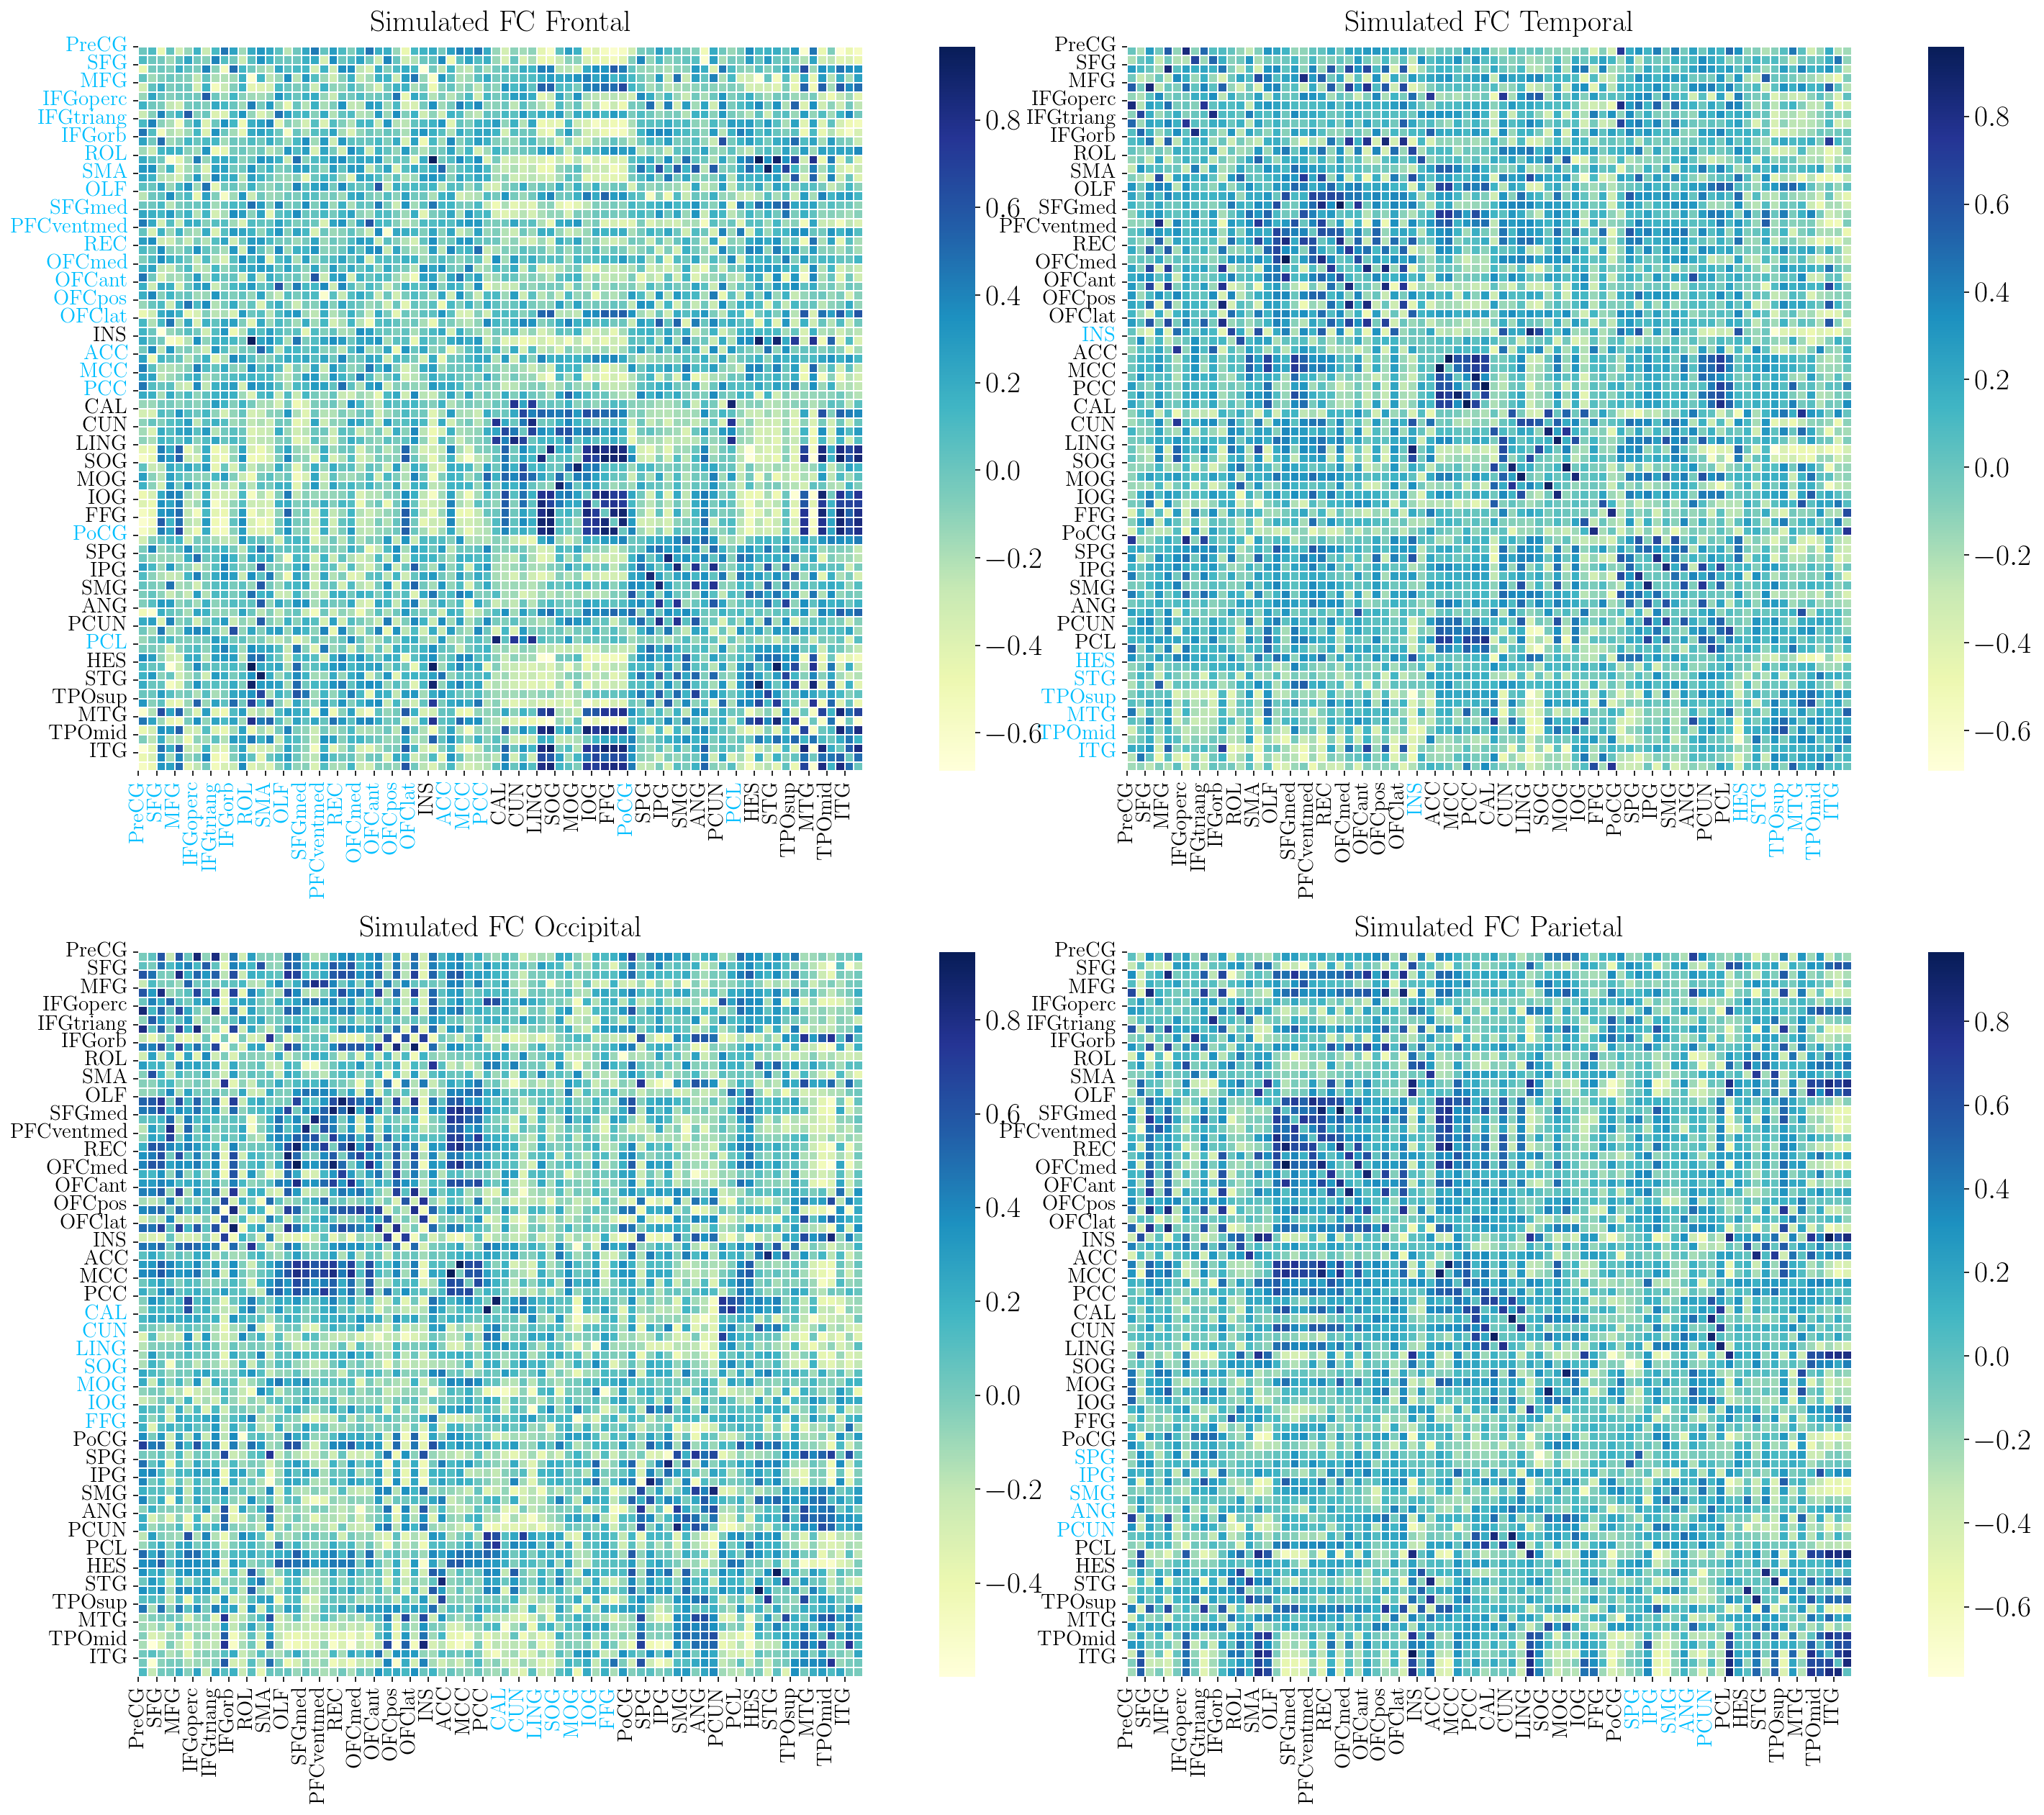

In [71]:
import neurolib.utils.functions as func

# Compute the functional connectivity matrix
sim_fc_frontal = func.fc(sim_signal_frontal.data)
sim_fc_temporal = func.fc(sim_signal_temporal.data)
sim_fc_occipital = func.fc(sim_signal_occipital.data)
sim_fc_parietal = func.fc(sim_signal_parietal.data)
# Set diagonal to zero
np.fill_diagonal(sim_fc_frontal, 0)
np.fill_diagonal(sim_fc_temporal, 0)
np.fill_diagonal(sim_fc_occipital, 0)
np.fill_diagonal(sim_fc_parietal, 0)

# Plot Empirical and simulated connectivity matrix
fig, ax = plt.subplots(2,2, figsize=(30,20))
#sns.heatmap(emp_fc, square=True, ax=ax[0], cmap='YlGnBu', linewidth=0.005, cbar_kws={"shrink": .5})
#ax[0].set_title('Empirical FC',pad=10);
sns.heatmap(sim_fc_frontal, square=True, ax=ax[0][0], cmap='YlGnBu', linewidth=0.005)
ax[0][0].set_title('Simulated FC Frontal',pad=10, size=20);
sns.heatmap(sim_fc_temporal, square=True, ax=ax[0][1], cmap='YlGnBu', linewidth=0.005)
ax[0][1].set_title('Simulated FC Temporal',pad=10, size=20);
sns.heatmap(sim_fc_occipital, square=True, ax=ax[1][0], cmap='YlGnBu', linewidth=0.005)
ax[1][0].set_title('Simulated FC Occipital',pad=10, size=20);
sns.heatmap(sim_fc_parietal, square=True, ax=ax[1][1], cmap='YlGnBu', linewidth=0.005)
ax[1][1].set_title('Simulated FC Parietal',pad=10, size=20);

ticks = [tick[:-2] for tick in emp_labels[::2]]

ax[0][0].set_xticks(np.arange(0,80,2)); ax[0][0].set_yticks(np.arange(0,80,2))    
ax[0][0].set_xticklabels(ticks, rotation=90, fontsize=14); ax[0][0].set_yticklabels(ticks, rotation=0, fontsize=14);

ax[0, 0].get_xticklabels()[0].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[1].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[2].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[3].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[4].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[5].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[6].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[7].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[8].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[9].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[10].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[11].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[12].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[13].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[14].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[15].set_color("deepskyblue")

ax[0, 0].get_xticklabels()[17].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[18].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[19].set_color("deepskyblue")

ax[0, 0].get_xticklabels()[27].set_color("deepskyblue")
ax[0, 0].get_xticklabels()[33].set_color("deepskyblue")



ax[0, 0].get_yticklabels()[0].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[1].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[2].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[3].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[4].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[5].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[6].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[7].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[8].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[9].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[10].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[11].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[12].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[13].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[14].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[15].set_color("deepskyblue")

ax[0, 0].get_yticklabels()[17].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[18].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[19].set_color("deepskyblue")

ax[0, 0].get_yticklabels()[27].set_color("deepskyblue")
ax[0, 0].get_yticklabels()[33].set_color("deepskyblue")


ax[0][1].set_xticks(np.arange(0,80,2)); ax[0][1].set_yticks(np.arange(0,80,2))    
ax[0][1].set_xticklabels(ticks, rotation=90, fontsize=14); ax[0][1].set_yticklabels(ticks, rotation=0, fontsize=14);

ax[0, 1].get_xticklabels()[16].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[34].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[35].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[36].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[37].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[38].set_color("deepskyblue")
ax[0, 1].get_xticklabels()[39].set_color("deepskyblue")

ax[0, 1].get_yticklabels()[16].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[34].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[35].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[36].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[37].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[38].set_color("deepskyblue")
ax[0, 1].get_yticklabels()[39].set_color("deepskyblue")

ax[1][0].set_xticks(np.arange(0,80,2)); ax[1][0].set_yticks(np.arange(0,80,2))    
ax[1][0].set_xticklabels(ticks, rotation=90, fontsize=14); ax[1][0].set_yticklabels(ticks, rotation=0, fontsize=14);

ax[1, 0].get_xticklabels()[20].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[21].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[22].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[23].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[24].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[25].set_color("deepskyblue")
ax[1, 0].get_xticklabels()[26].set_color("deepskyblue")

ax[1, 0].get_yticklabels()[20].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[21].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[22].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[23].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[24].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[25].set_color("deepskyblue")
ax[1, 0].get_yticklabels()[26].set_color("deepskyblue")



ax[1][1].set_xticks(np.arange(0,80,2)); ax[1][1].set_yticks(np.arange(0,80,2))    
ax[1][1].set_xticklabels(ticks, rotation=90, fontsize=14); ax[1][1].set_yticklabels(ticks, rotation=0, fontsize=14);

ax[1, 1].get_xticklabels()[28].set_color("deepskyblue")
ax[1, 1].get_xticklabels()[29].set_color("deepskyblue")
ax[1, 1].get_xticklabels()[30].set_color("deepskyblue")
ax[1, 1].get_xticklabels()[31].set_color("deepskyblue")
ax[1, 1].get_xticklabels()[32].set_color("deepskyblue")

ax[1, 1].get_yticklabels()[28].set_color("deepskyblue")
ax[1, 1].get_yticklabels()[29].set_color("deepskyblue")
ax[1, 1].get_yticklabels()[30].set_color("deepskyblue")
ax[1, 1].get_yticklabels()[31].set_color("deepskyblue")
ax[1, 1].get_yticklabels()[32].set_color("deepskyblue")

fig.subplots_adjust(wspace=-0.25)
fig.subplots_adjust(hspace=0.25)
fig.savefig('meg_comparison_scz.png',bbox_inches='tight')